In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_circles
import warnings
warnings.filterwarnings('ignore')

import torch 
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset 
import torch.nn.functional as F
import torch.nn as nn

from symreg import evaluate_composition, evaluate_tree, SymReg
np.random.seed(0)

In [2]:
def contains_pattern(sequence, pattern):
    pattern_str = ''.join(map(str, pattern))
    sequence_str = ''.join(map(str, sequence))
    return pattern_str in sequence_str

In [3]:
all_nums = []
for i in range(16):
    all_nums.append(list(map(int, np.binary_repr(i, 4))))
all_nums = np.array(all_nums)
y1 = np.array([contains_pattern(i, [1, 0, 1]) for i in all_nums])
y2 = []
for i in all_nums:
    cnt = 0
    for j in range(0, 2):
        if contains_pattern(i[j:j+3], [1, 1, 1]):
            cnt+=1
    y2.append(cnt)
y2 = np.array(y2)


In [4]:
rs = np.random.RandomState(42)
y1_new = list(range(len(all_nums)))
while y1[y1_new].mean() != 0.5:
    if y1[y1_new].mean()>0.5:
        to_add = [i for i in range(len(all_nums)) if y1[i] == 0]
    else:
        to_add = [i for i in range(len(all_nums)) if y1[i] == 1]
    to_add = rs.choice(to_add)
    y1_new.append(to_add)
y1 = y1[y1_new]
y1.mean(), len(y1)

(0.5, 24)

In [5]:
train_dataset = all_nums[y1_new], y1
test_dataset = train_dataset

In [6]:
from collections import Counter
rs = np.random.RandomState(42)
y2_new = list(range(len(all_nums)))
cnt0 = (y2[y2_new]==0).sum()
cnt1 = (y2[y2_new]==1).sum()
cnt2 = (y2[y2_new]==2).sum()

while (cnt0 != cnt1) or (cnt1 != cnt2):
    to_add = np.argsort([cnt0, cnt1, cnt2])[0]
    to_add = [i for i in range(len(all_nums)) if y2[i] == to_add]
    to_add = rs.choice(to_add)
    y2_new.append(to_add)
    cnt0 = (y2[y2_new]==0).sum()
    cnt1 = (y2[y2_new]==1).sum()
    cnt2 = (y2[y2_new]==2).sum()


y2 = y2[y2_new]
Counter(y2), len(y2)

(Counter({0: 13, 1: 13, 2: 13}), 39)

In [7]:
train_dataset2 = all_nums[y2_new], y2
test_dataset2 = train_dataset2

In [8]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=10.0)
model.fit(train_dataset[0], train_dataset[1])
print (np.equal(model.predict(test_dataset[0]), test_dataset[1]).mean())

0.7916666666666666


In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_dataset2[0], train_dataset2[1])
print (((model.predict(test_dataset2[0]) - test_dataset2[1])**2).mean())

0.1352328030798286


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
D = 4

class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(
            1, 1, kernel_size=3)  # 4 фильтра, каждый ищет свой шаблон
        self.pool = lambda x: x.max(1).values.max(1).values  #nn.AdaptiveMaxPool2d(1)  # "обобщает" по всему пространству
        self.fc = nn.Linear(1, 1)  # логрегрессия по 4 признакам

    def forward(self, x):
        x = x.view(-1, 1, D).float()
        x = self.conv(x)  # [B, 2, H-2, W-2]
        
        x = self.pool(x)  # [B, 2, 1, 1]

        x = x.view(x.size(0), -1)  # [B, 2]
        x = self.fc(x)  # [B, 1]
        return x  # [B, 1]

epochs = 1000
model = SimpleCNN()
opt = torch.optim.Adam(model.parameters(), lr=1e-1)
tq = tqdm.tqdm(range(1000))
for e in tq:
    opt.zero_grad()
    out = model(torch.tensor(train_dataset[0])).view(-1)
    
    loss = torch.nn.BCEWithLogitsLoss()(out, torch.tensor(train_dataset[1]).float())
    loss.backward()
    opt.step()
    tq.set_description(str(loss.item()))

3.5831475543091074e-05: 100%|██████████| 1000/1000 [00:03<00:00, 319.37it/s]


In [18]:
out = model( torch.tensor(test_dataset[0]))>0.0
torch.eq(out.view(-1), torch.tensor(test_dataset[1]).view(-1)).float().mean()


tensor(1.)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
D = 4

class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(
            1, 1, kernel_size=3)  # 4 фильтра, каждый ищет свой шаблон
        self.pool = lambda x: torch.nn.functional.leaky_relu(x).sum(1).sum(1)  #nn.AdaptiveMaxPool2d(1)  # "обобщает" по всему пространству
        self.fc = nn.Linear(1, 1)  # логрегрессия по 4 признакам

    def forward(self, x):
        x = x.view(-1, 1, D).float()
        x = self.conv(x)  # [B, 2, H-2, W-2]
        
        x = self.pool(x)  # [B, 2, 1, 1]

        x = x.view(x.size(0), -1)  # [B, 2]
        x = self.fc(x)  # [B, 1]
        return x  # [B, 1]

epochs = 1000
model = SimpleCNN()
opt = torch.optim.Adam(model.parameters(), lr=1e-1)
tq = tqdm.tqdm(range(1000))
for e in tq:
    opt.zero_grad()
    out = model(torch.tensor(train_dataset2[0])).view(-1)
    
    loss = ((out - torch.tensor(train_dataset2[1]))**2).mean()
    loss.backward()
    opt.step()
    tq.set_description(str(loss.item()))

6.205542740644887e-05: 100%|██████████| 1000/1000 [00:03<00:00, 297.42it/s]


In [20]:
out = model(torch.tensor(train_dataset2[0])).view(-1)
((out - torch.tensor(train_dataset2[1]))**2).mean()


tensor(6.1797e-05, grad_fn=<MeanBackward0>)

In [22]:
X_all = np.vstack([train_dataset[0], train_dataset2[0]])
y_all = np.hstack([train_dataset[1], train_dataset2[1]])
X_all.shape, y_all.shape

((63, 4), (63,))

In [23]:
train_dataset[0].shape

(24, 4)

In [24]:
from scipy.optimize import minimize
from symreg import evaluate_composition

import zlib


def compress_score(expression_str: str):
    compressed = zlib.compress(expression_str.encode('utf-8'))
    return len(compressed)

def acc_loss_fn_min(x, y, ind, variables, pool, OPERATIONS):
    COMP_SCORE = 1e-4
    if COMP_SCORE:        
        compl = compress_score(';'.join([str(h) for h in ind.children_h
                                     ]))  
        
    else:
        compl = 0.0
    
    
    x_train1 = {f'x{i}':x[:24, i] for i in range(4)}
    y_train1 = y[:24]
    
    x_train2 = {f'x{i}':x[24:, i] for i in range(4)}
    y_train2 = y[24:]
    
    def min_func(x0, var_y):
        var_, y_ = var_y
        pool_ = {f'p{i}': x0[i] for i in range(len(x0))}
    
        y_pred = evaluate_composition(ind, var_, pool_, OPERATIONS) > 0
        errs = -np.equal(y_, y_pred).mean()
        return errs
    
    x_opt = minimize(min_func, list(pool.values()),[x_train1, y_train1])
    loss1 = min_func(x_opt.x, [x_train1, y_train1])
    """
    hidden1, out1 = evaluate_composition(ind, x_train1, {f'p{i}': x_opt.x[i] for i in range(len(x_opt.x))}, 
                                             OPERATIONS, 0, True)
    hidden1_array = []
    for h in hidden1.values():
        h = np.array(h)
        if len(h.shape) == 0:
            h = np.ones(24) * h
        hidden1_array.append(h)
    hidden1_array = np.array(hidden1_array).T
    mi = micd(hidden1_array, y_train1)
    """
        
    
    def min_func2(x0, var_y):
        var_, y_ = var_y
        pool_ = {f'p{i}': x0[i] for i in range(len(x0))}
        y_pred = evaluate_composition(ind, var_, pool_, OPERATIONS, g_id=1) 
        y_pred = np.clip(y_pred, 0, 2)
        errs = ((y_ - y_pred)**2).mean()/2
        return errs
    
    x_opt = minimize(min_func2, list(pool.values()),[x_train2, y_train2])
    
    loss2 = 0.0
    loss2 = min_func2(x_opt.x, [x_train2, y_train2])
    loss = (loss1 + loss2)/2 + compl * COMP_SCORE
   
    return loss, loss1, loss2, compl #, mi

In [ ]:
import operator
reduced_operations = {
    'add': (operator.add, 2),
    'sub': (operator.sub, 2),
    'mult': (operator.mul, 2),
    'max': (np.maximum, 2)
}
import time
time_s = time.time()
run_num = 1
gens = [[] for _ in range(run_num)]
for r in range(run_num):
    symreg = SymReg(acc_loss_fn_min,
                    X_all,
                    y_all,
                    3,
                    2,
                    2,
                    2,
                    1000,
                    proc_num = -1,
                    operations=reduced_operations,
                    mutate_params=False)
    symreg.fit(5, 1, 1, 1)
print (time.time() - time_s)

[Gen 0] Expr: 
h_0 = x2
h_1 = max(mult(add(p1, p0), sub(p0, p1)), sub(add(p0, sub(add(add(p0, p0), mult(x1, p0)), p1)), sub(p0, x2)))
g_0 = add(max(add(p1, h1), sub(h1, p1)), sub(sub(h0, p0), max(p0, h1)))
g_1 = mult(max(max(h1, h0), mult(h0, h0)), h1)
[Gen 0] Best errors: (-0.27093538946501416, -0.6666666666666666, 0.1111958877366382, 68.0)
[Gen 0] Total time: 7.024469375610352
[Gen 1] Expr: 
h_0 = x2
h_1 = max(mult(add(p1, p0), sub(p0, p1)), sub(add(p0, sub(add(add(p0, p0), mult(x1, p0)), p1)), sub(p0, x2)))
g_0 = add(max(add(p1, h1), sub(h1, p1)), sub(sub(h0, p0), max(p0, h1)))
g_1 = mult(max(max(h1, h0), mult(h0, h0)), h1)
[Gen 1] Best errors: (-0.27093538946501416, -0.6666666666666666, 0.1111958877366382, 68.0)
[Gen 1] Total time: 15.89748477935791
[Gen 2] Expr: 
h_0 = x2
h_1 = max(mult(add(p1, p0), sub(p0, p1)), sub(add(p0, sub(add(add(p0, p0), mult(x1, p0)), p1)), sub(p0, x2)))
g_0 = add(max(add(p1, h1), sub(h1, p1)), sub(sub(h0, p0), max(p0, h1)))
g_1 = mult(max(max(h1, h0), mu

In [19]:
r = ['a', 'b'], ['c', 'd']
def f(x, y):
    print ('x', x)
    print ('y', y)
f(*r)

x ['a', 'b']
y ['c', 'd']


('add(x0, add(mult(p0, x1), x2))', 4, 1)

In [118]:
for r in range(run_num):
    subgen = sorted(gens[r][0], key = lambda x: x.fitness)[-1]
    print (subgen)


h_0 = add(add(add(p3, x0), add(p1, p2)), mult(mult(x1, p1), add(x2, p0)))
h_1 = max(sub(mult(x0, sub(add(x1, p0), add(mult(x2, p3), sub(x3, p0)))), x1), max(mult(p3, x2), mult(x3, x1)))
g_0 = mult(max(max(h1, p0), max(p0, p3)), add(add(sub(sub(h1, p0), max(p2, max(max(mult(h1, p2), max(p0, p2)), h0))), h1), sub(h0, p1)))
g_1 = max(max(mult(h1, h0), max(mult(h1, mult(h0, sub(h1, h0))), mult(sub(mult(p2, p0), sub(h1, h1)), mult(h1, p2)))), p3)


In [59]:
from onetask_hid_pool import Node, DEFAULT_OPERATIONS, Composition

In [61]:
x1 = Node('x0')
x2 = Node('x1')
x3 = Node('x2')
x4 = Node('x3')
p0 = Node('p0')
p1 = Node('p1')
mx1 = Node('mult', [p0, x2])
mx2 = Node('mult', [p0, x3])

mx11 = Node('add', [mx1, x3])
mx22 = Node('add', [mx2, x4])

h1 = Node('add', [x1, mx11])
h2 = Node('add', [x2, mx22])
h1_ = Node('h0')
h2_ = Node('h1')
g0 = Node('max', [h1_, h2_])
comp = Composition([h1, h2], [Node('add', [g0, p0])])
print(comp)


h_0 = add(x0, add(mult(p0, x1), x2))
h_1 = add(x1, add(mult(p0, x2), x3))
g_0 = add(max(h0, h1), p0)


In [64]:

np.equal(np.round(evaluate_composition(comp, {f'x{i}':X_all[:24,i] for i in range(4)}, {'p0':  -1.0}, DEFAULT_OPERATIONS)) > 0, y_all[:24])


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [42]:
hiddens, res = evaluate_composition(comp, {f'x{i}':X_all[:,i] for i in range(4)}, {'p0':  -1.0}, DEFAULT_OPERATIONS, True)

In [43]:
hiddens = np.array(list(hiddens.values())).T

In [47]:
micd(hiddens, Y_all), compress_score(str(h1)+';'+str(h2)), np.corrcoef(hiddens.T)

(1.1316154984981068,
 46,
 array([[ 1.        , -0.79416553],
        [-0.79416553,  1.        ]]))

In [45]:
def simple_mi(h, y):
    mi = 0.0
    for _ in range(100):
        # Случайная проекция (например, гауссовская)
        P = np.random.randn(h.shape[1], 1)  # Проекция на 1 признак

        # Вычисление ковариации между x и проекцией y
        cov_matrix = np.cov(h @ P, y.reshape(-1, 1).T, rowvar=False)
        mi += cov_matrix[0, 1]**2
    return mi

In [46]:
from mi import micd
conv_out = model.conv(train_dataset[0]).view(100, -1)
conv_out.shape
simple_mi(conv_out.detach().numpy(), train_dataset[1]), micd(conv_out.detach().numpy(), train_dataset[1])

RuntimeError: Given groups=1, weight of size [1, 1, 3], expected input[1, 100, 4] to have 1 channels, but got 100 channels instead

In [14]:
from sklearn.metrics import mutual_info_score
from onetask_hid_pool import evaluate_tree


def discretize(vec, bins=10):
    return np.digitize(vec, bins=np.histogram_bin_edges(vec, bins=bins))





def acc_loss_fn(x, y, ind, variables, pool, OPERATIONS):
    new_vars = []

    mi = 0.0

    for h_id, h in enumerate(ind.children_h):
        res = np.array(evaluate_tree(h, variables | pool, OPERATIONS))
        if len(res.shape) == 0:
            res = np.ones(x.shape[0]) * res
        new_vars.append(res)

    new_vars = np.array(new_vars).T
    try:
        mi = float(micd(new_vars, y))  #simple_mi(new_vars, y)
    except:
        mi = 10000000.0

    y_pred = evaluate_composition(ind, variables, pool, OPERATIONS) > 0
    result = np.equal(y, y_pred).mean()
    loss = result
    compl = compress_score(';'.join([str(h) for h in ind.children_h
                                     ]))  #composition_node_num(ind)

    corr = abs(np.corrcoef(new_vars.T))
    corr[corr != corr] = 1.0
    corr = corr.mean()
    return -loss + compl * 0.00001 + mi * 0.001 + corr * 1.0, loss, compl, mi, corr

In [146]:
import operator
DEFAULT_OPERATIONS = {
    'add': (operator.add, 2),
    'sub': (operator.sub, 2),
    'mult': (operator.mul, 2),
    'max': (np.maximum, 2)
}


best, trees = run_deap_gp(acc_loss_fn,
                          4,
                          16,
                          16,
                          X_all,
                          Y_all,
                          generations=1000,
                          raise_error=True,
                          log_perf_every=10,
                          log_models_every=-1,
                          OPERATIONS=DEFAULT_OPERATIONS
                          )
print("Best expression:", best)


NameError: name 'acc_loss_fn' is not defined

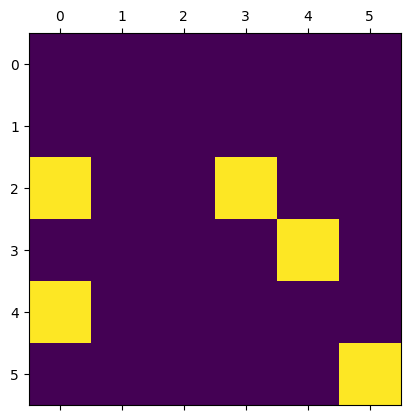

In [27]:
mat = np.zeros((6, 6))
i = np.unravel_index([12, 15, 22, 24, 35], [6, 6])
mat[i] = 1
plt.matshow(mat)

In [13]:
from scipy.optimize import minimize


def acc_loss_fn_min(x, y, ind, variables, pool, OPERATIONS):

    def min_func(x0):
        
        pool_ = {f'p{i}': x0[i] for i in range(len(x0))}
        y_pred = evaluate_composition(ind, variables, pool_, OPERATIONS) > 0
        result = np.equal(y, y_pred).mean()
        return result

    x_opt = minimize(min_func, list(pool.values()))
    loss = min_func(x_opt.x)
    compl = composition_node_num(ind)
    return -loss + compl * 1e-10, loss, compl

In [16]:
best, trees = run_deap_gp(acc_loss_fn_min,
                          2,
                          36,
                          16,
                          X_all,
                          Y_all,
                          generations=10000,
                          raise_error=True,
                          log_perf_every=100,
                          log_models_every=-1,
                          mutate_params=False
                          
                          )
print("Best expression:", best)


[Gen 0] Best errors: (-0.4999999857, 0.5, 143.0)
[Gen 100] Best errors: (-0.5899999949, 0.59, 51.0)
[Gen 200] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 300] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 400] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 500] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 600] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 700] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 800] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 900] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 1000] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 1100] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 1200] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 1300] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 1400] Best errors: (-0.6099999956, 0.61, 44.00000000000001)
[Gen 1500] Best errors: (-0.6099999956, 0.61, 44.00000000000001

KeyboardInterrupt: 